In [1]:
%matplotlib inline

In [29]:
import pandas as pd
import networkx as nx
import itertools
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('test_SyncDiagnosis.csv')

In [4]:
df.head()

,DiagnosisGuid,PatientGuid,ICD9Code,DiagnosisDescription,StartYear,StopYear,Acute,UserGuid
0,AD58C335-C62E-4E4C-A5C9-00005C89DA06,44C0A13A-C841-4063-A2A7-CFADA3785F23,V70.0,Routine general medical examination at a healt...,2010,NaN,0,7511BCEC-9E46-4808-99A7-5B30778B6E84
1,74D1CE08-CD1E-4199-86D3-0001AED0AB24,F2B45907-C559-4077-B2FE-04F354DAB00D,719.45,Pain in joint involving pelvic region and thigh,0,NaN,0,4773B833-9CD4-41E8-895B-846DC1EA7279
2,AFFFEAEF-B454-4FC5-869D-00075A844CEB,1BB806A8-87EE-42B4-960B-5035E84A03C1,780.60,"Fever, unspecified",0,NaN,0,86ACD71A-7F64-43EA-8772-EAD4E1FEF45E
3,11C037C5-0388-4FDB-B777-0007BB0CC51A,CFD993EE-32AD-4A19-821C-71A0438074A6,272.4,Other and unspecified hyperlipidemia,0,NaN,0,2103028E-E805-4F50-A280-407DC423400B
4,F5076968-D5D2-41C9-9C1C-000B8C16CC9D,633FE254-009D-481C-9A3C-8610B2121D0F,465.9,Acute upper respiratory infections of unspecif...,2011,NaN,0,FE52114B-620C-454E-BACA-0B0C7BDF3F32


In [5]:
df.count()

DiagnosisGuid           47911
PatientGuid             47911
ICD9Code                47911
DiagnosisDescription    47911
StartYear               47911
StopYear                 2432
Acute                   47911
UserGuid                47911
dtype: int64

In [6]:
grouping = df.groupby(['PatientGuid', 'DiagnosisDescription'])
df_processed = grouping.count()['DiagnosisGuid'].to_frame().reset_index().drop('DiagnosisGuid', 1)

In [9]:
current_patient = ''
patient_diagosis_dict = {}
for record in df_processed.head(500).iterrows():
    patient = record[1]['PatientGuid']
    diagnosis = record[1]['DiagnosisDescription']
    
    if patient != current_patient:
        current_patient = patient
        patient_diagosis_dict[current_patient] = [diagnosis]
    else:
        patient_diagosis_dict[current_patient] += [diagnosis]

In [10]:
G = nx.Graph()
for patient in patient_diagosis_dict.keys():
    diagnosis = patient_diagosis_dict[patient]
    edges = list(itertools.combinations(diagnosis, 2))
    for edge in edges:
        u = edge[0]
        v = edge[1]
        if (u, v) in G.edges():
            data = G.get_edge_data(u, v)#, key='edge')
            G.add_edge(u, v, key='edge', weight=data['weight']+1)
        else:
            G.add_edge(u, v, key='edge', weight=1)

In [11]:
G.number_of_nodes()

303

In [12]:
G.number_of_edges()

3231

In [13]:
nx.write_gexf(G, 'net.gexf')

In [14]:
nx.write_gml(G, 'net.gml')

In [27]:
corr = nx.to_pandas_dataframe(G).corr()

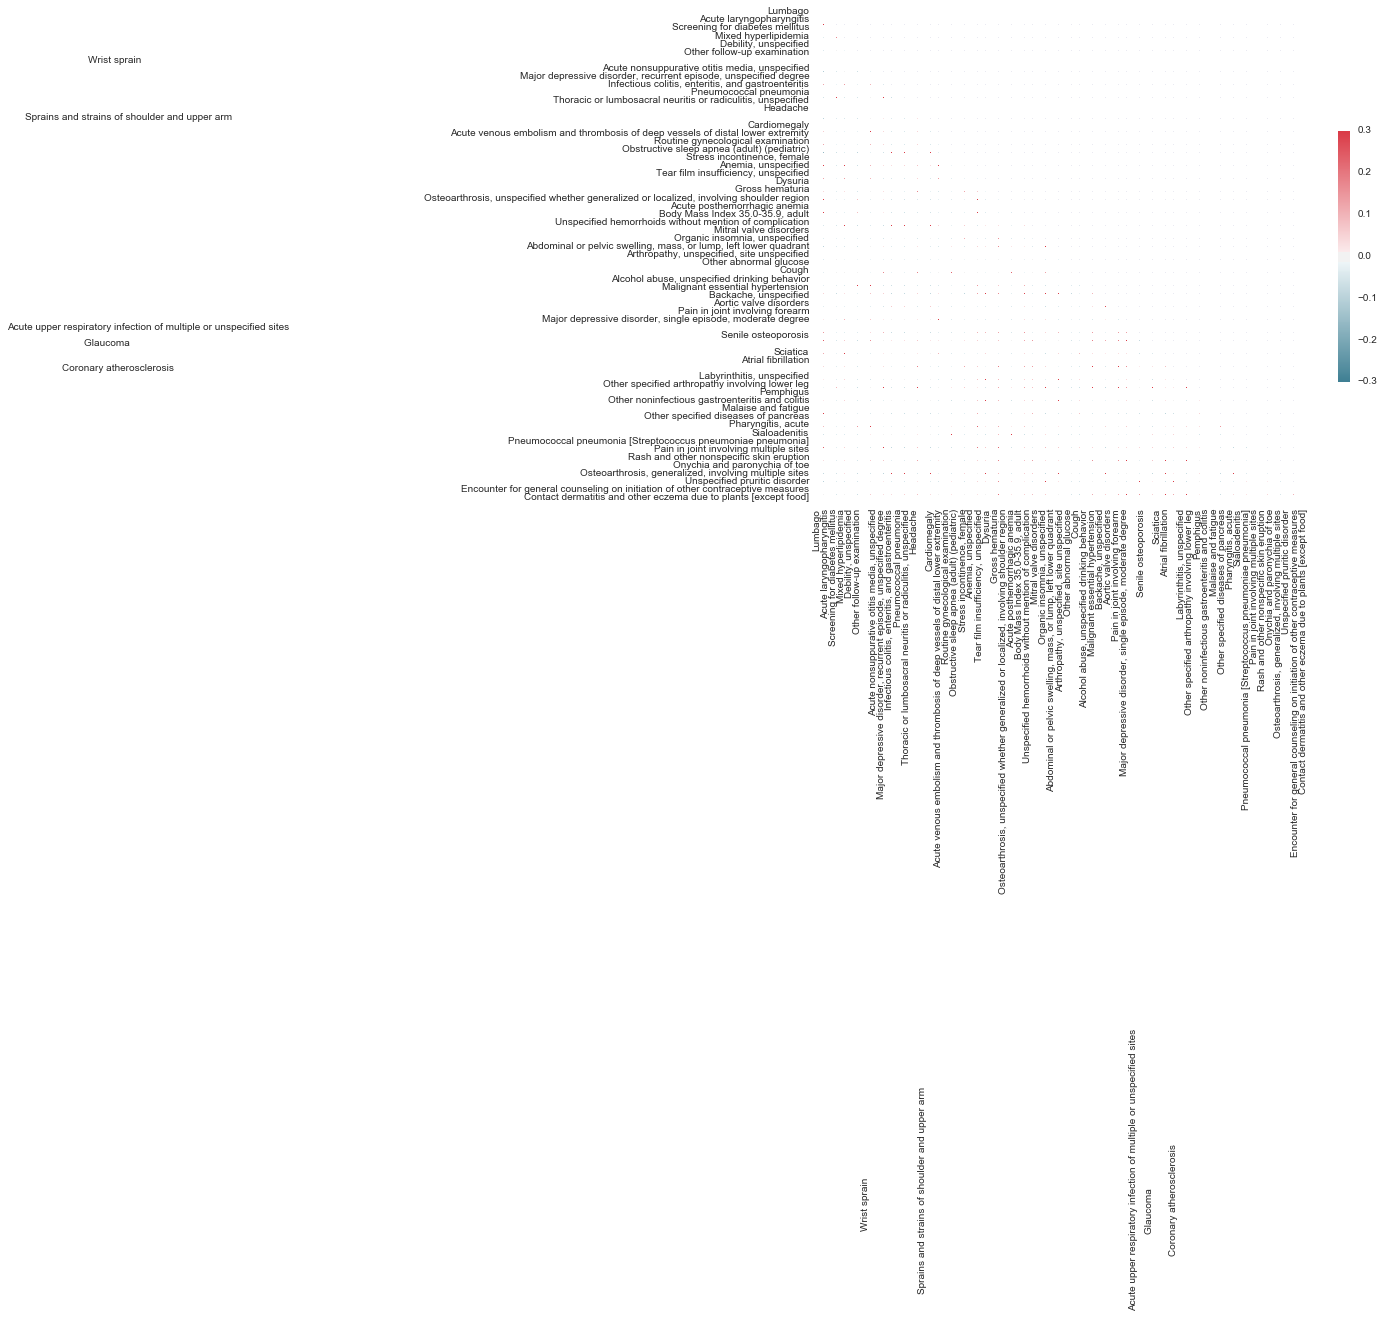

In [30]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)